# Sep 27, 2025: distinct community shapes
and effective number of shapes

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats
from scipy.spatial.distance import jensenshannon, squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from typing import Tuple

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

load solution modes

In [12]:
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-SLC01/partition-modes-group-aligned/{SBM}/desc-modes.pkl'))
grp_df = []
for file in indiv_files:
    with open(file, 'rb') as f:
        df = pickle.load(f)
    grp_df += [df]

In [14]:
boot_files = sorted(glob.glob(f'{ESTIM_path_boot}/individual/boot-*/partition-modes-group-aligned/{SBM}/desc-modes.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 65/65 [03:49<00:00,  3.53s/it]


In [15]:
pis_df = pd.concat(grp_df + boots_df).reset_index(drop=True)

In [16]:
pis_df

,sub,sbm,mode_aligned,omega
0,grp,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.257972
1,grp,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.141756
2,grp,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.126375
3,grp,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.121384
4,grp,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.076945
...,...,...,...,...
749,69,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.095832
750,69,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.049330
751,69,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.043835
752,69,sbm-nd-h,<graph_tool.inference.partition_modes.Partitio...,0.029299


collect partitions at level 1

In [38]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fe2470f7620>

In [24]:
level = 1

In [26]:
def get_M(b):
    b = np.array(b).reshape(-1, 1)
    categories = np.arange(-1, np.max(b)+1).tolist() # first one indicating absence of comm. in the partition
    enc = OneHotEncoder(sparse_output=False, categories=[categories])
    M = enc.fit_transform(b)
    return M

In [ ]:
for idx, row in pis_df.iterrows():
    mode = row['mode_aligned']
    break

for bs_ in list(mode.get_nested_partitions().values()):
    bs_ = gt.nested_partition_clear_null(bs_)
    s = gt.NestedBlockState(g, bs=bs_)
    state = gt.NestedBlockState(g, bs=b)
    b = np.array(list(state.project_level(1).get_blocks()))

---

load membership matrices

In [11]:
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-SLC01/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
grp_df = []
for file in indiv_files:
    with open(file, 'rb') as f:
        df = pickle.load(f)
    grp_df += [df]

In [12]:
boot_files = sorted(glob.glob(f'{ESTIM_path_boot}/individual/boot-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 30/30 [00:00<00:00, 847.23it/s]


In [13]:
pis_df = pd.concat(grp_df + boots_df).reset_index(drop=True)
# pis_df

In [14]:
def make_same_shape(Ms: list):
    num_rois = Ms[0].shape[0]
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    return Rs

In [15]:
cols = [c for c in pis_df.columns if 'pi' in c]

In [16]:
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [17]:
def keep_select_comms(args: ARGS, Ms: list):
    Ms = np.stack(Ms)
    Ms = Ms[:, :, args.select_comms]
    return [Ms[i, :, :] for i in range(Ms.shape[0])]

In [18]:
args.select_comms = np.arange(0, 9) # for pi_1_aligned only
i = 1
cols1 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) < i]
cols2 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) > i]
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols1],
        pis_df[cols[i:i+1]].apply(lambda pis: keep_select_comms(args, pis.to_list())),
        pis_df[cols2],
    ],
    axis=1
)

In [19]:
pis_df

,sub,sbm,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0.257972,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9496124031007752, 0.0, 0.0, 0.050387596899...","[[0.7008741858183528, 0.26384418100130885, 0.0...","[[0.9260830842147051, 0.01793128917935009, 0.0...","[[0.9921355376037768, 0.0021095634328647164, 0...","[[0.9971515016854993, 0.0001158046687140191, 0...","[[0.9972094040198562, 0.0027326936457866768, 5...","[[0.9999999999999999, 0.0, 0.0, 0.0], [1.0, 0....","[[0.9999999999999999, 0.0], [1.0, 0.0], [0.999..."
1,grp,sbm-nd-h,0.141756,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9014084507042254, 0.0, 0.03521126760563380...","[[0.6443703991799266, 0.28282091773565143, 0.0...","[[0.9183218461451625, 0.037281345932509355, 0....","[[0.9818965352199229, 0.008284743540557636, 0....","[[0.9979288141148607, 0.0, 0.0, 0.002071185885...","[[0.9979288141148607, 0.0, 0.0, 0.002071185885...","[[0.9979288141148607, 0.002071185885139409, 0....","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."
2,grp,sbm-nd-h,0.126375,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9603174603174603, 0.0, 0.02380952380952380...","[[0.8383975812547242, 0.14635928445452254, 0.0...","[[0.9877527924750147, 0.01097694633408919, 0.0...","[[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....","[[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....","[[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....","[[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....","[[1.0, 0.0], [0.9999999999999999, 0.0], [1.0, ..."
3,grp,sbm-nd-h,0.121384,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.8347107438016529, 0.15702479338842976, 0.0...","[[0.9265969746811219, 0.011317102226193136, 0....","[[0.9985853622217258, 0.001414637778274142, 0....","[[0.9999999999999999, 0.0, 0.0, 0.0], [1.0, 0....","[[0.9999999999999999, 0.0, 0.0, 0.0], [1.0, 0....","[[0.9999999999999999, 0.0, 0.0, 0.0], [1.0, 0....","[[0.9999999999999999, 0.0], [1.0, 0.0], [1.0, ..."
4,grp,sbm-nd-h,0.076945,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.974025974025974, 0.0, 0.025974025974025976...","[[0.27828425846197546, 0.6198347107438016, 0.0...","[[0.9249677407128295, 0.06439841150584952, 0.0...","[[0.9842355095437625, 0.00804980143823119, 0.0...","[[0.9914636721012164, 0.0004865264605524346, 0...","[[0.9919501985617689, 0.0, 0.0, 0.008049801438...","[[0.9919501985617689, 0.00804980143823119, 0.0...","[[0.9919501985617689, 0.00804980143823119], [0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
328,39,sbm-nd-h,0.043151,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.813953488372093, 0.0, 0.023255813953488372...","[[0.4886725557358332, 0.3985938345051379, 0.01...","[[0.9725141527336262, 0.012857865629197997, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."
329,39,sbm-nd-h,0.033267,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.6060606060606061, 0.3939393939393939, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0], [1.000000000000000...","[[1.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0000000000000002, 0....","[[1.0, 0.0], [1.0000000000000002, 0.0], [1.000..."
330,39,sbm-nd-h,0.029238,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.41379310344827586, 0.3103448275862069, 0.0...","[[0.8748513674197383, 0.06500198176773682, 0.0...","[[0.9711950059453031, 0.0, 0.02880499405469679...","[[0.9999999999999999, 0.0, 0.0, 0.0], [1.00000...","[[0.9999999999999999, 0.0, 0.0, 

unique comm shapes

In [20]:
def compute_distances(config_matrix):
    # config_matrix : num_modes x num_rois
    distances = pdist(config_matrix, metric='cityblock') # metric='cosine'
    # distances /= np.max(distances) # normalize distances
    # distances /= config_matrix.shape[1] # num_modes
    distances = np.nan_to_num(distances)
    dist_matrix = squareform(distances)
    return dist_matrix, distances

def perform_hierarchical_clustering(dist_matrix, threshold=0.1):
    distances = squareform(dist_matrix)
    num_points = dist_matrix.shape[0]

    if not len(distances) > 0: return None, np.array([1]), {}
    
    if num_points == 1:
        best_k = 1
        clusters = np.ones(1, dtype=int)
        return None, clusters, {}

    Z = linkage(distances, method='average')

    if num_points == 2:
        if dist_matrix[0, 1] < threshold:
            best_k = 1
            clusters = np.ones(2, dtype=int)
        else:
            best_k = 2
            clusters = np.array([1, 2], dtype=int)
        return Z, clusters, {}

    silhuette_scores = {}
    best_score = -1
    best_k = 1
    for k in range(2, num_points+1):
        labels = fcluster(Z, k, criterion='maxclust')
        try:
            score = silhouette_score(dist_matrix, labels, metric='precomputed')
            silhuette_scores[k] = score
            if score > best_score:
                best_score = score
                best_k = k
        except:
            continue
    
    if best_score <= 0:
        best_k = 1
        clusters = np.ones(num_points, dtype=int) # single cluster
    else:
        clusters = fcluster(Z, best_k, criterion='maxclust')
    return Z, clusters, silhuette_scores

def relabel_clusters_by_weight(clusters, omegas):
    clusters = np.asarray(clusters)
    omegas = np.asarray(omegas)
    
    n_clusters = clusters.max() + 1
    cluster_weights = np.bincount(clusters, weights=omegas, minlength=n_clusters)
    
    # Sort clusters by decreasing total weight → new label: 0 for max weight
    sorted_clusters = np.argsort(-cluster_weights)
    relabel_map = {old: new for new, old in enumerate(sorted_clusters)}
    
    return np.array([relabel_map[c] for c in clusters])

def compute_cluster_probabilities(clusters, omegas):
    if len(omegas) > 1:
        return np.bincount(clusters, weights=omegas)
    else:
        return np.array([1.0])

def compute_effective_number_of_configs(probs):
    return np.exp(stats.entropy(probs))

def get_unique_configs(config_matrix, clusters):
    # encdr : num_modes x num_clusters
    encdr = OneHotEncoder(
        sparse_output=False,
    ).fit_transform(clusters.reshape(-1, 1))
    # mean configuration within each cluster, 
    # config_matrix.T : num_rois x num_modes
    # cluster_configs : num_rois x num_clusters (per comm)
    unique_configs =  np.round(
        config_matrix.T @ encdr / encdr.sum(axis=0),
        decimals=3,
    )
    return unique_configs

def sort_cluster_results(cluster_probs, unique_configs):
    sort_idx = np.argsort(cluster_probs)[::-1] # decreasing order
    sorted_probs = cluster_probs[sort_idx]
    sorted_configs = unique_configs[:, sort_idx]
    return sorted_probs, sorted_configs

def analyze_configs_per_comm(config_matrix, omegas, threshold=0.1):
    dist_mat, dists = compute_distances(config_matrix)
    Z, clusters, silhuette_scores = perform_hierarchical_clustering(dist_mat, threshold)
    clusters = relabel_clusters_by_weight(clusters, omegas)
    cluster_probs = compute_cluster_probabilities(clusters, omegas)
    eff_num_configs = compute_effective_number_of_configs(cluster_probs)
    unique_configs = get_unique_configs(config_matrix, clusters)
    # cluster_probs, unique_configs = sort_cluster_results(cluster_probs, unique_configs)

    return (
        clusters, 
        eff_num_configs,
        cluster_probs,
        unique_configs,
        dist_mat,
        silhuette_scores,
    )

def analyze_configs_per_col(args, sub, SBM, col, M, omegas, threshold=0.1):  
    num_modes, num_rois, num_comms = M.shape
    col_df = []
    for comm in range(num_comms):
        (
            clusters,
            eff_num_configs, 
            cluster_strengths, 
            unique_configs,
            dist_mat,
            silhuette_scores,
        ) = analyze_configs_per_comm(M[:, :, comm], omegas, threshold=threshold)
        crow = pd.DataFrame(dict(
            sub=[sub],
            sbm=[SBM],
            col=[col],
            comm=[comm],
            clusters=[clusters],
            eff_num_configs=[eff_num_configs],
            strengths=[cluster_strengths],
            configs=[unique_configs],
            distance_matrix=[dist_mat],
            silhuette_scores=[silhuette_scores],
        ))
        col_df += [crow]
    col_df = pd.concat(col_df).reset_index(drop=True)
    return col_df

def analyze_configs_per_sub(args, sub, SBM, cols, group, threshold=0.1):
    configs_sub_df = []
    for col in cols:
        M = np.stack(group[col].to_list())
        omegas = group['omega'].to_numpy()
        col_df = analyze_configs_per_col(args, sub, SBM, col, M, omegas, threshold=threshold)
        configs_sub_df += [col_df]
    return pd.concat(configs_sub_df).reset_index(drop=True)

In [21]:
analysis_df = []
threshold = 0.05 # threshold based on eff_num of amygdala (comm ??). 0.3 for source-spatial, and 0.1 for source-allen
for sub, group in tqdm(pis_df.groupby('sub')):
    # display(group)
    # if len(group) == 1: continue
    analysis_df += [analyze_configs_per_sub(args, sub, SBM, cols, group, threshold)]
analysis_df = pd.concat(analysis_df).reset_index(drop=True)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


In [22]:
analysis_df[analysis_df['col'].isin(['pi_1_aligned'])]

,sub,sbm,col,comm,clusters,eff_num_configs,strengths,configs,distance_matrix,silhuette_scores
45,00,sbm-nd-h,pi_1_aligned,0,"[0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...",1.999535,"[0.5107821564312863, 0.48921784356871384]","[[0.827, 0.91], [0.0, 0.001], [0.076, 0.009], ...","[[0.0, 6.0199547938549625, 12.378167941751027,...","{2: 0.42097020253466555, 3: 0.4050032271681055..."
46,00,sbm-nd-h,pi_1_aligned,1,"[0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...",2.156859,"[0.7196079215843171, 0.19124624924984998, 0.08...","[[0.01, 0.0, 0.0], [0.949, 0.881, 1.0], [0.572...","[[0.0, 2.047351729834165, 29.261462824068275, ...","{2: 0.48327335864185406, 3: 0.5315073685595989..."
47,00,sbm-nd-h,pi_1_aligned,2,"[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, ...",1.812579,"[0.7180876175235048, 0.2819123824764953]","[[0.131, 0.046], [0.063, 0.007], [0.217, 0.273...","[[0.0, 3.297782793702688, 9.503774502230085, 1...","{2: 0.4247382815309711, 3: 0.35115192181285415..."
48,00,sbm-nd-h,pi_1_aligned,3,"[0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, ...",1.897346,"[0.6782556511302261, 0.3197199439887978, 0.002...","[[0.01, 0.037, 0.0], [0.0, 0.0, 0.0], [0.073, ...","[[0.0, 1.1938598518685095, 0.9871184742047212,...","{2: 0.5213149423685233, 3: 0.6203256602433087,..."
49,00,sbm-nd-h,pi_1_aligned,4,"[0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...",2.187074,"[0.7175835167033409, 0.19124624924984998, 0.08...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.004, 0.0, 0.0],...","[[0.0, 2.586772694997802, 31.360091484370333, ...","{2: 0.5755010935652387, 3: 0.620416006419476, ..."
...,...,...,...,...,...,...,...,...,...,...
2599,grp,sbm-nd-h,pi_1_aligned,4,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1.167005,"[0.9641751649670067, 0.0358248350329934]","[[0.003, 0.0], [0.0, 0.0], [0.0, 0.0], [0.009,...","[[0.0, 5.53847476591833, 16.133641317833543, 5...","{2: 0.46195489082454316, 3: 0.3616266385327765..."
2600,grp,sbm-nd-h,pi_1_aligned,5,"[0, 0, 1, 0, 0, 1, 0, 3, 2, 1, 1, 2]",2.479729,"[0.6542691461707659, 0.25266946610677865, 0.05...","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","[[0.0, 1.555600922981399, 14.516551407534948, ...","{2: 0.43447393464540746, 3: 0.4163645925736578..."
2601,grp,sbm-nd-h,pi_1_aligned,6,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]",1.245199,"[0.942763447310538, 0.05723655268946211]","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 1.2746097826200835, 10.912654774066349,...","{2: 0.3870099702701966, 3: 0.332512485840273, ..."
2602,grp,sbm-nd-h,pi_1_aligned,7,"[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]",1.823573,"[0.7115056988602281, 0.28849430113977204]","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[0.0, 0.562941191734418, 12.337338753380887, ...","{2: 0.688308899448458, 3: 0.65524703848664, 4:..."


HOW many shapes does a comm. adopt: effective number of distinct shapes

In [23]:
def plot_effective_numbers(long_df: pd.DataFrame):
    nrows = sorted(long_df['comm'].unique())
    nrows = len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (comm,), group in long_df.groupby(by=['comm']):
        
        ax = axs[comm]
        
        sns.boxplot(
            group, 
            ax=ax, 
            y='eff_num_configs',
            color='grey',
            fill=False, 
            width=0.5, 
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='eff_num_configs',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5, 
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylim=[1, 3], yticks=[1, 1.5, 2, 2.5, 3], yticklabels=['1', '', '2', '', '3'])
        ax.set(ylabel=f'C. {comm+1:02d}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


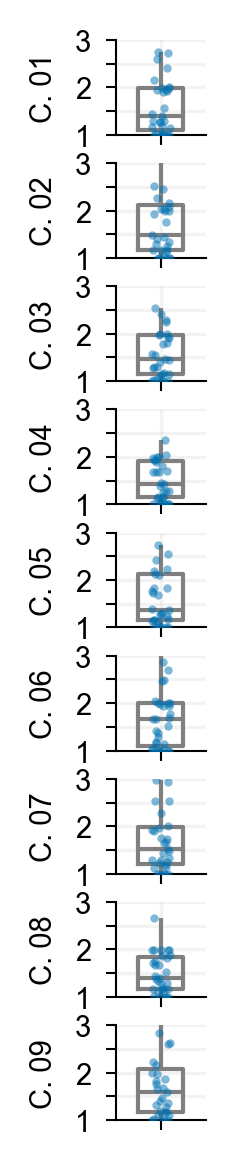

In [24]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = analysis_df[analysis_df['col'].isin([col])]
    g = plot_effective_numbers(long_df)
    g.savefig(f'{folder}/level-{level}_desc-eff-num-shapes.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-eff-num-shapes.png', transparent=True, dpi=300, bbox_inches='tight')

WHERE do transitions to alternate shapes happen: distributed across modes or concentrated in a few?

In [25]:
shape_transitions_df = []
for (col, sub), group in analysis_df.groupby(by=['col', 'sub']):
    # print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    
    comm_clusters = np.stack(group['clusters'].to_list())
    num_rare_shapes = np.sum(comm_clusters > 0, axis=0)
    avg_transitions = np.median(num_rare_shapes) / comm_clusters.shape[0] # divide by num_comms

    row = dict(
        sub=sub,
        sbm=SBM,
        col=col,
        num_rare_shapes=num_rare_shapes,
        avg_transitions=avg_transitions,
    )
    shape_transitions_df += [row]
shape_transitions_df = pd.DataFrame(shape_transitions_df)
shape_transitions_df['col'] = shape_transitions_df['col'].map(
    lambda x: x.replace('pi', '').replace('_', '').replace('aligned', '')
)

In [26]:
shape_transitions_df

,sub,sbm,col,num_rare_shapes,avg_transitions
0,00,sbm-nd-h,0,"[3, 6, 5, 6, 3, 6, 9, 6, 7, 8, 11, 9, 6, 8, 10...",0.155556
1,01,sbm-nd-h,0,[0],0.000000
2,02,sbm-nd-h,0,"[0, 0, 1, 1, 4, 7, 1, 6, 4, 6, 10, 9, 9]",0.088889
3,03,sbm-nd-h,0,"[0, 6, 10, 2, 7, 11, 13, 7, 4, 10, 13, 11, 17]",0.222222
4,04,sbm-nd-h,0,[0],0.000000
...,...,...,...,...,...
274,28,sbm-nd-h,8,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",0.000000
275,29,sbm-nd-h,8,"[0, 1, 0, 1, 0, 0, 0]",0.000000
276,38,sbm-nd-h,8,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000
277,39,sbm-nd-h,8,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000


In [27]:
def plot_rare_transitions(long_df: pd.DataFrame):
    nrows = sorted(long_df['col'].unique())
    nrows = len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (col,), group in long_df.groupby(by=['col']):
        col = int(col)
        ax = axs[col]
        
        sns.boxplot(
            group, 
            ax=ax,
            y='avg_transitions',
            color='grey',
            fill=False, 
            width=0.5,
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax,
            y='avg_transitions',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5,
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylabel=f'Level {col}', ylim=[0, 1], yticks=[0, 0.5, 1],)
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

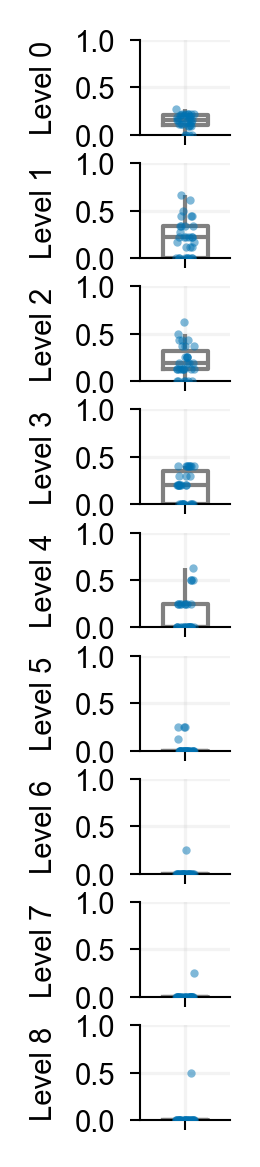

In [28]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

g = plot_rare_transitions(shape_transitions_df)
g.savefig(f'{folder}/desc-rare-transitions.svg', transparent=True, dpi=300, bbox_inches='tight')
g.savefig(f'{folder}/desc-rare-transitions.png', transparent=True, dpi=300, bbox_inches='tight')

HOW different are the shapes: stable fractions ?

In [29]:
ROI_SYS_path = f'{ROI_path}/canonical-systems/joanes'
v = np.loadtxt(f'{ROI_SYS_path}/desc-roi-vox-counts.csv') # n_rois

In [30]:
def compute_stable_fraction(strengths, configs, v, tol=0.01):
    comm_mask = ~np.all(configs <= tol, axis=1)
    diffs = np.abs(configs[comm_mask, :] - configs[comm_mask][:, [0]])
    wdiffs = diffs * strengths
    stable_frac = np.sum(v[comm_mask] * np.all(wdiffs <= tol, axis=1)) / np.sum(v * comm_mask) # account for voxels within ROIs
    stable_frac = np.round(stable_frac, decimals=3)
    return np.nan_to_num(stable_frac)

In [31]:
tol = 0.01
stable_fracs = analysis_df.apply(lambda row: compute_stable_fraction(row['strengths'], row['configs'], v, tol=tol), axis=1)

In [32]:
stable_fracs_df = pd.concat(
    [
        analysis_df[['sub', 'sbm', 'col', 'comm']],
    ],
    axis=1,
)
stable_fracs_df['stable_frac'] = stable_fracs
stable_fracs_df[stable_fracs_df['col'].isin(cols[1:2])]

,sub,sbm,col,comm,stable_frac
45,00,sbm-nd-h,pi_1_aligned,0,0.106
46,00,sbm-nd-h,pi_1_aligned,1,0.368
47,00,sbm-nd-h,pi_1_aligned,2,0.187
48,00,sbm-nd-h,pi_1_aligned,3,0.446
49,00,sbm-nd-h,pi_1_aligned,4,0.392
...,...,...,...,...,...
2599,grp,sbm-nd-h,pi_1_aligned,4,0.742
2600,grp,sbm-nd-h,pi_1_aligned,5,0.188
2601,grp,sbm-nd-h,pi_1_aligned,6,0.633
2602,grp,sbm-nd-h,pi_1_aligned,7,0.228


In [33]:
def plot_stable_fractions(long_df: pd.DataFrame):
    nrows = sorted(long_df['comm'].unique())
    nrows = len(nrows)
    ncols = 1
    
    height = 0.5 #inches
    aspect = 0.75
    width = height * aspect 
    
    fig_height = height * nrows
    fig_width = width * ncols
    
    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height),
        sharey=True,
    )
    
    fig.subplots_adjust(
        left=0.1, 
        right=0.9, 
        bottom=0.1,
        top=0.9, 
        wspace=0.3, 
        hspace=0.3,
    )
    
    for (comm,), group in long_df.groupby(by=['comm']):
        
        ax = axs[comm]
        
        sns.boxplot(
            group, 
            ax=ax, 
            y='stable_frac',
            color='grey',
            fill=False, 
            width=0.5, 
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='stable_frac',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5, 
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylim=[0, 1], yticks=[0, 0.5, 1])
        ax.set(ylabel=f'C. {comm+1:02d}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


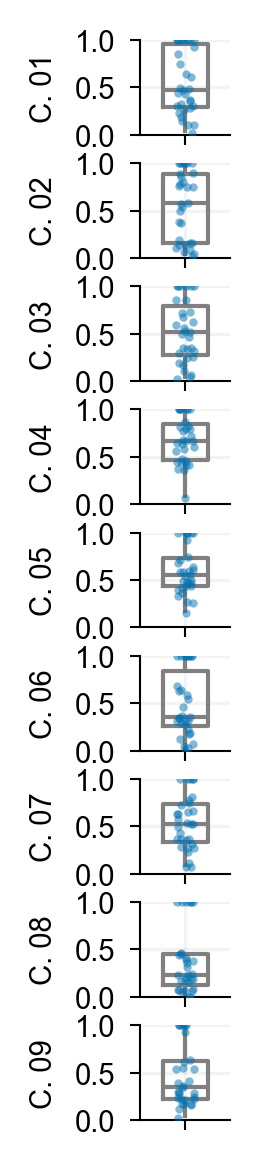

In [34]:
folder = f'{ESTIM_path}/group/multiplicity/community/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = stable_fracs_df[stable_fracs_df['col'].isin([col])]
    g = plot_stable_fractions(long_df)
    g.savefig(f'{folder}/level-{level}_desc-stable-fractions.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-stable-fractions.png', transparent=True, dpi=300, bbox_inches='tight')

WHAT are the shapes: are the shapes generalizable across population?

In [35]:
def make_same_shape(Ms: list):
    M = Ms[0]
    num_rois = M.shape[0] if np.ndim(M) > 1 else 1
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    Rs = [np.squeeze(R) for R in Rs]
    return Rs

In [36]:
configs_df = analysis_df[analysis_df['col'].isin(cols[1:2])]

In [37]:
configs_df = pd.concat(
    [
        configs_df[['sub', 'sbm', 'col', 'comm']],
        configs_df[['strengths', 'configs']].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [38]:
col = cols[1]
long_df = configs_df[configs_df['col'].isin([col])]
long_df

,sub,sbm,col,comm,strengths,configs
45,00,sbm-nd-h,pi_1_aligned,0,"[0.5107821564312863, 0.48921784356871384, 0.0,...","[[0.827, 0.91, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0,..."
46,00,sbm-nd-h,pi_1_aligned,1,"[0.7196079215843171, 0.19124624924984998, 0.08...","[[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.949,..."
47,00,sbm-nd-h,pi_1_aligned,2,"[0.7180876175235048, 0.2819123824764953, 0.0, ...","[[0.131, 0.046, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0..."
48,00,sbm-nd-h,pi_1_aligned,3,"[0.6782556511302261, 0.3197199439887978, 0.002...","[[0.01, 0.037, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0,..."
49,00,sbm-nd-h,pi_1_aligned,4,"[0.7175835167033409, 0.19124624924984998, 0.08...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."
...,...,...,...,...,...,...
2599,grp,sbm-nd-h,pi_1_aligned,4,"[0.9641751649670067, 0.0358248350329934, 0.0, ...","[[0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, ..."
2600,grp,sbm-nd-h,pi_1_aligned,5,"[0.6542691461707659, 0.25266946610677865, 0.05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."
2601,grp,sbm-nd-h,pi_1_aligned,6,"[0.942763447310538, 0.05723655268946211, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."
2602,grp,sbm-nd-h,pi_1_aligned,7,"[0.7115056988602281, 0.28849430113977204, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."


In [39]:
def find_generalizable_shapes(
    all_shapes: np.ndarray
) -> Tuple[np.ndarray, float, float]:
    """
    Analyzes community shapes across bootstrap samples to find generalizable forms.

    This function takes a collection of dominant community shapes from multiple
    bootstrap samples, clusters them using k-means, and validates the
    generalizability of the resulting cluster centroids (population-level shapes).

    Args:
        all_shapes: A NumPy array of shape (n_samples, n_rois, k), where
                    n_samples is the number of bootstrap samples (e.g., 100),
                    n_rois is the number of brain regions, and
                    k is the number of dominant shapes per sample to analyze.
                    The shapes for each sample should be ordered by plausibility.

    Returns:
        A tuple containing:
        - population_shapes (np.ndarray): The cluster centroids, representing the
          k generalizable shapes. Shape: (k, n_rois).
        - silhouette (float): The silhouette score for the clustering, measuring
          how distinct the clusters are (higher is better, max is 1.0).
        - split_consistency (float): The percentage of bootstrap samples that
          contributed at least one shape to each of the k clusters.
    """
    # Infer parameters from the input matrix shape
    n_samples, n_rois, k = all_shapes.shape

    # Step 1: Pool all shapes into a single "bag of shapes"
    # Reshape from (100, n_rois, k) to (100*k, n_rois) for clustering
    pooled_shapes = all_shapes.transpose(0, 2, 1).reshape(-1, n_rois)

    # Step 2: Perform k-means clustering to find k population-level shapes
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_assignments = kmeans.fit_predict(pooled_shapes)
    population_shapes = kmeans.cluster_centers_

    # Step 3: Validate the results

    # 3a. Calculate silhouette score to measure cluster separation
    silhouette = silhouette_score(pooled_shapes, cluster_assignments)

    # 3b. Calculate split consistency to measure generalizability
    # Reshape assignments back to (n_samples, k) to check each sample
    assignments_per_sample = cluster_assignments.reshape(n_samples, k)

    # Count how many samples have shapes in all k clusters
    n_consistent_samples = 0
    for i in range(n_samples):
        # A sample is consistent if its k shapes span all k clusters
        if len(np.unique(assignments_per_sample[i, :])) == k:
            n_consistent_samples += 1
    
    split_consistency = np.round(n_consistent_samples / n_samples, decimals=3)

    return population_shapes, silhouette, split_consistency, assignments_per_sample

In [40]:
for (comm,), group in long_df.groupby(by=['comm']):
    break

Cs = np.stack(group['configs'].to_list())
Ss = group['strengths'].to_list()
Cs = np.round(Cs, decimals=3)
Ss = np.round(Ss, decimals=3)
Cs.shape, Ss.shape

((31, 172, 7), (31, 7))

In [41]:
Cs = Cs[:, :, :2]
pop_shapes, sil, consistency, assignments_per_sample = find_generalizable_shapes(Cs)

In [42]:
sil

0.3008802922374165

In [43]:
assignments_per_sample

array([[1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0]], dtype=int32)